# Benthic Habitat Mapping with Hyperspectral Remote Sensing

## Mapping the Seafloor from Space Using Planet Tanager Data

---

**The Science Question:**

> *"Can we map what's on the seafloor in shallow coastal waters using hyperspectral imagery - and does having 400+ spectral bands help compared to traditional multispectral sensors?"*

---

In this notebook, we'll explore an exciting application of hyperspectral remote sensing: **seeing through water to map the seafloor**.

In clear, shallow coastal waters, sunlight penetrates to the bottom, reflects off the substrate (sand, seagrass, coral, algae), and travels back up through the water column to a satellite sensor. Different bottom types have distinct spectral signatures - unique "fingerprints" of how they reflect light at different wavelengths.

With traditional **multispectral** sensors like Landsat or Sentinel-2 (3-10 broad bands), these signatures can look frustratingly similar. But with **hyperspectral** data from Planet's Tanager satellite (426 narrow bands), we can detect subtle absorption features that distinguish between different habitats.

### Why Does This Matter?

- **Seagrass meadows** are one of the most effective carbon sinks on Earth, storing carbon 35x faster than tropical rainforests
- **Coastal habitat monitoring** is critical for fisheries management and biodiversity conservation
- **Climate change** and human activities are rapidly altering shallow marine ecosystems
- Traditional field surveys are expensive, time-consuming, and can only cover small areas

Satellite-based mapping offers a scalable solution - but only if we can accurately distinguish between different habitat types.

### From Raw Data to Usable Information

Satellite data doesn't come ready to use. The raw measurements include contributions from:

- **The atmosphere** — scattering and absorption by gases, aerosols, and water vapor
- **Sun-sensor geometry** — the angles of illumination and viewing affect apparent brightness
- **The water surface** — sun glint and reflection at the air-water interface
- **The water column** — absorption and scattering by water itself
- **The seafloor** — what we actually want to measure!

The Tanager data we downloaded is **top-of-atmosphere (TOA) radiance** — the total light that reached the sensor. To extract meaningful information about the seafloor, we need **atmospheric correction** to remove the atmospheric (and for water, surface and water column) contributions.

The result is **remote sensing reflectance (Rrs)** — a physically meaningful quantity representing light leaving the water. This is what Acolite will compute for us.

For water applications, atmospheric correction is especially critical. When a satellite looks at the ocean, **85-95% of the light it detects never even touched the water** — it's sunlight scattered back by the atmosphere. The actual signal from the water (and seafloor) is just 5-15% of the total. Without correction, we'd be trying to see through overwhelming atmospheric "noise."

### What You'll Learn

1. What hyperspectral data is and why it matters for coastal applications
2. How to load and visualize Planet Tanager data using HyperCoast
3. How to extract and interpret spectral signatures from different benthic types
4. Why atmospheric correction is critical for water applications
5. How to classify benthic habitats using spectral data
6. The quantitative advantage of hyperspectral over multispectral data

---

**Study Area:** Abu Dhabi, UAE - Persian Gulf coast  
**Why this location:** Crystal-clear shallow waters, distinct benthic types (sand, seagrass beds, darker substrates), minimal river input means low turbidity

**Estimated time:** 15-20 minutes

---

## 1. Background: Hyperspectral vs. Multispectral Remote Sensing

### What's the Difference?

Imagine you're trying to identify different types of fabric by their color:

- **Multispectral** is like seeing in **RGB** - you can tell red from blue, but two shades of burgundy might look identical
- **Hyperspectral** is like seeing in **400+ colors** - suddenly you can distinguish between cotton burgundy, silk burgundy, and wool burgundy

| Feature | Multispectral (e.g., Sentinel-2) | Hyperspectral (Tanager) |
|---------|----------------------------------|-------------------------|
| Number of bands | ~10 | 426 |
| Band width | Broad (~20-100nm) | Narrow (~5nm) |
| Spectral range | Visible + some NIR/SWIR | 380-2500nm (continuous) |
| Spatial resolution | 10-60m | ~30m |
| Absorption features | Missed or averaged out | Captured precisely |

### Why Does This Matter for Underwater Mapping?

Different materials absorb light at specific wavelengths:
- **Chlorophyll** (in seagrass and algae) absorbs strongly around **675nm**
- **Water** absorbs increasingly in the **red and near-infrared**
- **Sand** reflects broadly across the visible spectrum

With 426 narrow bands, hyperspectral sensors can detect these subtle absorption features that get smoothed out in broad multispectral bands.

### Planet Tanager Mission

Planet's Tanager satellite, launched in **August 2024**, represents a new generation of commercial hyperspectral imaging:

- **426 spectral bands** from 380-2500nm (VSWIR range)
- **~5nm spectral resolution** - narrow enough to capture absorption features
- **~30m ground sample distance** - suitable for habitat-scale mapping
- **Global coverage** - enabling consistent monitoring worldwide

---

## 2. Setup and Data Access

Let's start by importing the libraries we'll need and downloading our study scene.

In [85]:
# Core libraries
import h5py
import numpy as np
import matplotlib.pyplot as plt
import xarray as xr
import os
import warnings

# For classification
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Suppress some warnings for cleaner output
warnings.filterwarnings('ignore', category=RuntimeWarning)
warnings.filterwarnings('ignore', category=FutureWarning)

print("Libraries loaded successfully!")

Libraries loaded successfully!


### Download the Tanager Scene

We'll use a scene from Abu Dhabi, UAE captured on May 11, 2025. This scene shows the shallow coastal waters of the Persian Gulf, which are known for their clarity and diverse benthic habitats.

The data is stored as an **HDF5 file** containing top-of-atmosphere (TOA) radiance values.

In [86]:
# Abu Dhabi scene - clear shallow waters with visible benthic features
url = "https://storage.googleapis.com/open-cogs/planet-stac/release1-basic-radiance/20250511_074311_00_4001_basic_radiance.h5"

# Download the file using a simple approach
import urllib.request

filename = "20250511_074311_00_4001_basic_radiance.h5"

if os.path.exists(filename):
    print(f"File already exists: {filename}")
else:
    print("Downloading Tanager scene... this may take a few minutes.")
    urllib.request.urlretrieve(url, filename)
    print("Download complete!")

filepath = filename
print(f"File size: {os.path.getsize(filepath) / 1e6:.1f} MB")

File already exists: 20250511_074311_00_4001_basic_radiance.h5
File size: 558.5 MB


### Read the Tanager Data

HyperCoast provides a convenient function to read Tanager HDF5 files into an xarray Dataset.

In [87]:
# Read the Tanager data from HDF5
with h5py.File(filepath, 'r') as f:
    # Read the radiance data and geolocation
    data = f["HDFEOS/SWATHS/HYP/Data Fields/toa_radiance"][()]
    lat = f["HDFEOS/SWATHS/HYP/Geolocation Fields/Latitude"][()]
    lon = f["HDFEOS/SWATHS/HYP/Geolocation Fields/Longitude"][()]

# Construct wavelength array based on Tanager specs
# 426 bands spanning ~380-2500nm (VSWIR range)
n_bands, n_rows, n_cols = data.shape
wavelengths = np.linspace(380, 2500, n_bands)

print(f"Data shape: {data.shape}")
print(f"  - {n_bands} spectral bands")
print(f"  - {n_rows} rows x {n_cols} columns")
print(f"Wavelength range: {wavelengths[0]:.0f} - {wavelengths[-1]:.0f} nm")
print(f"Latitude range: {np.nanmin(lat):.4f}° to {np.nanmax(lat):.4f}°")
print(f"Longitude range: {np.nanmin(lon):.4f}° to {np.nanmax(lon):.4f}°")

Data shape: (426, 624, 607)
  - 426 spectral bands
  - 624 rows x 607 columns
Wavelength range: 380 - 2500 nm
Latitude range: 23.9904° to 24.1919°
Longitude range: 53.6322° to 53.8941°


In [88]:
# Helper function to find the band index closest to a target wavelength
def find_band(target_wl):
    """Find the band index closest to a target wavelength."""
    return np.argmin(np.abs(wavelengths - target_wl))

# Show some example band-wavelength mappings
print("Band index to wavelength mapping:")
for wl in [450, 550, 650, 850, 1600, 2200]:
    idx = find_band(wl)
    print(f"  {wl}nm -> Band {idx} (actual: {wavelengths[idx]:.1f}nm)")

Band index to wavelength mapping:
  450nm -> Band 14 (actual: 449.8nm)
  550nm -> Band 34 (actual: 549.6nm)
  650nm -> Band 54 (actual: 649.4nm)
  850nm -> Band 94 (actual: 848.9nm)
  1600nm -> Band 245 (actual: 1602.1nm)
  2200nm -> Band 365 (actual: 2200.7nm)


**Key things to note:**
- The data contains **top-of-atmosphere (TOA) radiance** - the raw energy measured by the sensor
- We have **426 spectral bands** spanning the visible to shortwave infrared
- The data is **not gridded** to a regular coordinate system (HyperCoast handles the interpolation for visualization)
- Later, we'll need to perform **atmospheric correction** to convert this to surface reflectance

### Where in the World?

Before we dive into the imagery, let's see where our study area is located. The interactive map below shows the scene footprint on the coast of Abu Dhabi, UAE in the Persian Gulf.

In [89]:
# Create an interactive location map using folium
import folium
from folium.plugins import MiniMap

# Scene coordinates (hardcoded so this cell can run independently)
center_lat, center_lon = 24.0912, 53.7637
min_lat, max_lat = 23.9904, 24.1919
min_lon, max_lon = 53.6322, 53.8941

# Scene footprint corners
corners = [
    [min_lat, min_lon],
    [min_lat, max_lon],
    [max_lat, max_lon],
    [max_lat, min_lon],
    [min_lat, min_lon]  # Close the polygon
]

# Create a map centered on our study area
m = folium.Map(
    location=[center_lat, center_lon],
    zoom_start=10,
    tiles='CartoDB positron'
)

# Add the scene footprint as a polygon
folium.Polygon(
    locations=corners,
    color='red',
    weight=3,
    fill=True,
    fill_color='red',
    fill_opacity=0.2,
    popup='Tanager Scene: Abu Dhabi Coast'
).add_to(m)

# Add a mini map for global context
minimap = MiniMap(toggle_display=True, zoom_level_offset=-5)
m.add_child(minimap)

# Add different tile layer options
folium.TileLayer('OpenStreetMap').add_to(m)
folium.TileLayer(
    tiles='https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
    attr='Esri',
    name='Satellite'
).add_to(m)
folium.LayerControl().add_to(m)

print("Study Area: Abu Dhabi, UAE")
print(f"Scene center: {center_lat:.4f}°N, {center_lon:.4f}°E")
print(f"Scene extent: {min_lat:.4f}° to {max_lat:.4f}°N")
print(f"             {min_lon:.4f}° to {max_lon:.4f}°E")

# Display the map
m

Study Area: Abu Dhabi, UAE
Scene center: 24.0912°N, 53.7637°E
Scene extent: 23.9904° to 24.1919°N
             53.6322° to 53.8941°E


---

## 3. Initial Visualization

Let's visualize our scene. We'll select three bands to create a "natural color" composite similar to what our eyes would see.

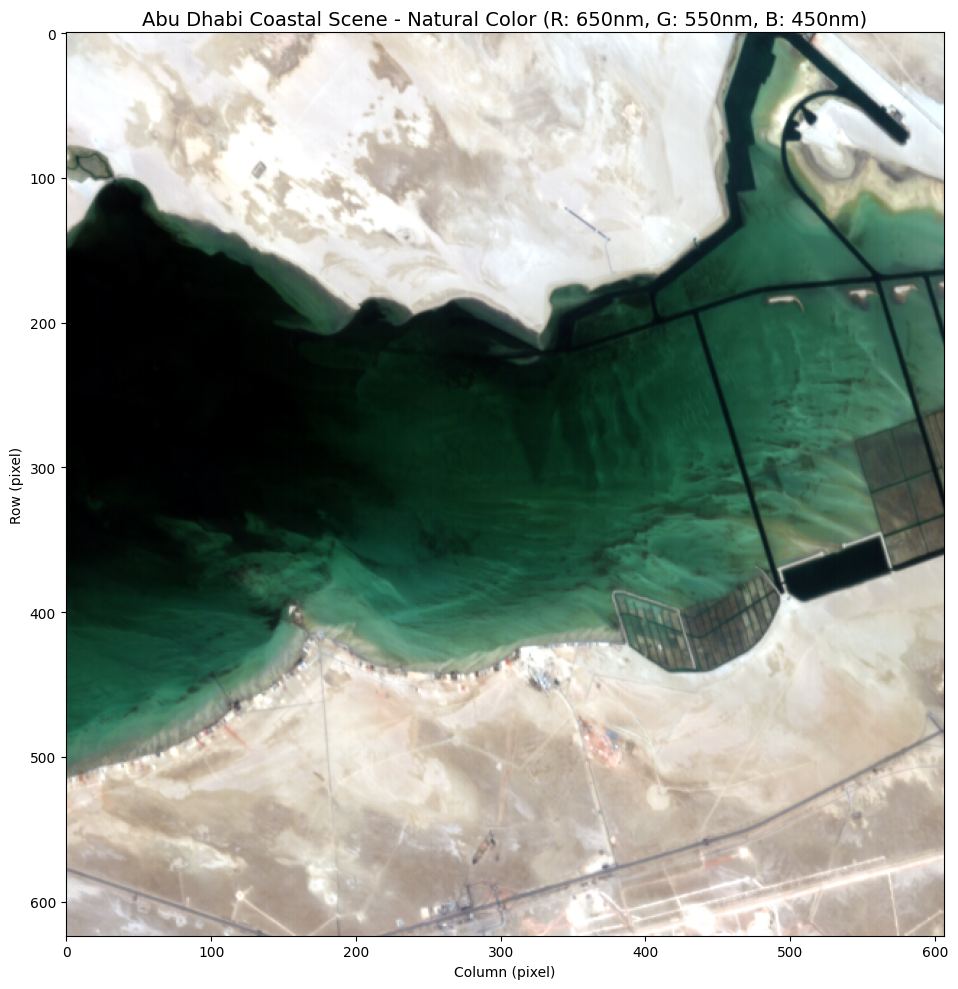

Image dimensions: 624 rows x 607 columns


In [90]:
# Create RGB composite for visualization
# Red ~650nm, Green ~550nm, Blue ~450nm
r_idx = find_band(650)
g_idx = find_band(550)  
b_idx = find_band(450)

# Stack into RGB array
rgb = np.stack([data[r_idx], data[g_idx], data[b_idx]], axis=-1)

# Normalize for display (stretch to 2nd-98th percentile)
rgb_display = rgb.copy()
for i in range(3):
    band = rgb_display[:, :, i]
    valid = ~np.isnan(band) & (band > 0)
    if valid.any():
        p2, p98 = np.percentile(band[valid], [2, 98])
        rgb_display[:, :, i] = np.clip((band - p2) / (p98 - p2 + 1e-10), 0, 1)
rgb_display = np.nan_to_num(rgb_display, nan=0)

# Display the scene
fig, ax = plt.subplots(figsize=(12, 10))
ax.imshow(rgb_display)
ax.set_title('Abu Dhabi Coastal Scene - Natural Color (R: 650nm, G: 550nm, B: 450nm)', fontsize=14)
ax.set_xlabel('Column (pixel)')
ax.set_ylabel('Row (pixel)')
plt.tight_layout()
plt.show()

print(f"Image dimensions: {rgb.shape[0]} rows x {rgb.shape[1]} columns")

**Explore the scene!**

Take a moment to examine the image. Notice:
- The **coastline** separating land from water
- **Shallow areas** where you can see the bottom (lighter blues/greens in the water)
- **Deeper areas** that appear darker teal/blue
- **Different bottom types** - can you spot areas where the seafloor looks different?
- **Land features** - agricultural plots and bare desert on the right side

### Understanding Wavelength Selection

With 426 bands to choose from, we can create any combination of "colors" we want. For natural color, we use:

| Color Channel | Wavelength | Why? |
|---------------|------------|------|
| Red | ~650nm | Visible red light |
| Green | ~550nm | Visible green light |
| Blue | ~450nm | Visible blue light |

But we can also create **false color** composites to highlight features that aren't visible to the human eye. Let's try using near-infrared (NIR) to highlight vegetation:

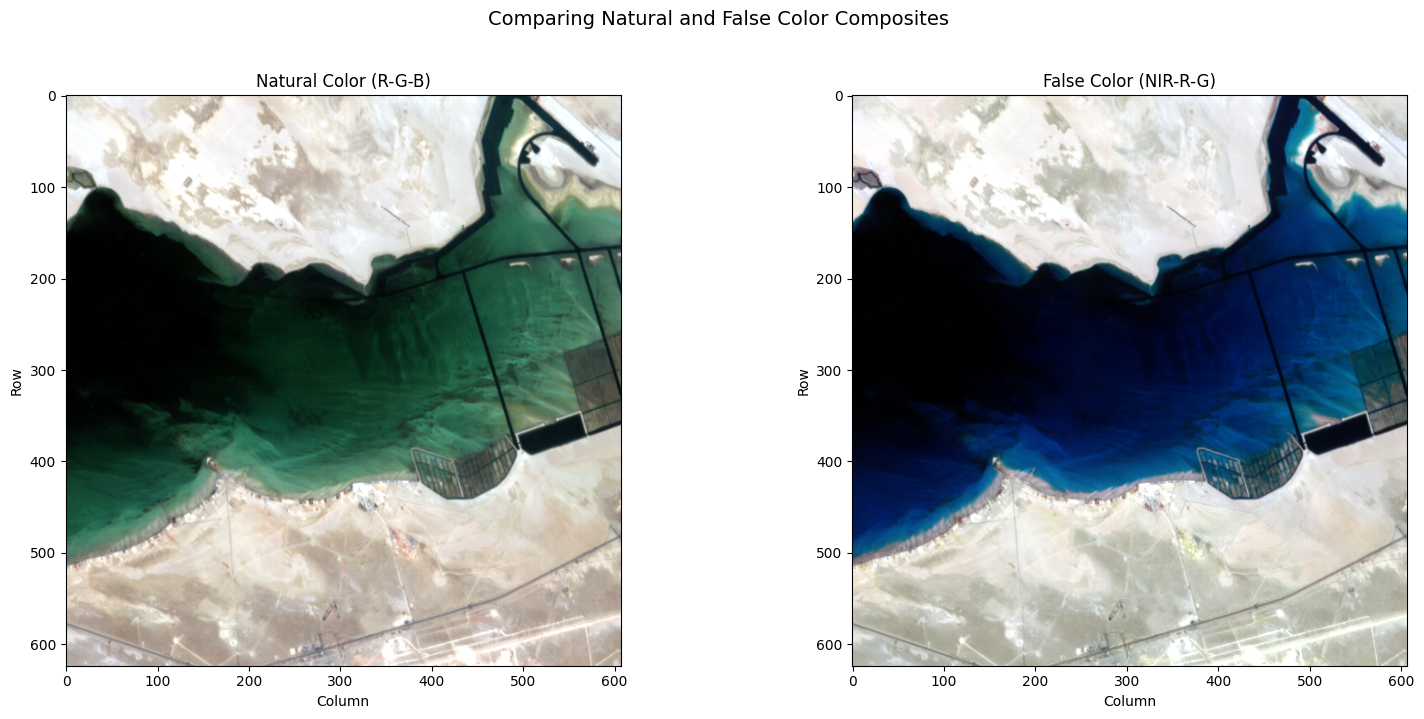

In [91]:
# False color composite: NIR, Red, Green
# This combination makes vegetation appear bright red/pink
nir_idx = find_band(850)

rgb_false = np.stack([data[nir_idx], data[r_idx], data[g_idx]], axis=-1)

# Normalize for display
rgb_false_display = rgb_false.copy()
for i in range(3):
    band = rgb_false_display[:, :, i]
    valid = ~np.isnan(band) & (band > 0)
    if valid.any():
        p2, p98 = np.percentile(band[valid], [2, 98])
        rgb_false_display[:, :, i] = np.clip((band - p2) / (p98 - p2 + 1e-10), 0, 1)
rgb_false_display = np.nan_to_num(rgb_false_display, nan=0)

# Display side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 7))

axes[0].imshow(rgb_display)
axes[0].set_title('Natural Color (R-G-B)', fontsize=12)
axes[0].set_xlabel('Column')
axes[0].set_ylabel('Row')

axes[1].imshow(rgb_false_display)
axes[1].set_title('False Color (NIR-R-G)', fontsize=12)
axes[1].set_xlabel('Column')
axes[1].set_ylabel('Row')

plt.suptitle('Comparing Natural and False Color Composites', fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

In the false-color view:
- **Vegetation on land** appears bright red/magenta (high NIR reflectance) - look at the agricultural areas
- **Water** appears very dark (water absorbs NIR strongly)
- **Bare land/desert** appears tan/yellow

This demonstrates why we need multiple wavelengths: different materials have different spectral "signatures" that we can exploit to identify them.

---

## 4. Exploring Spectral Signatures (Before Atmospheric Correction)

Now let's look at the **full spectral signature** - all 426 bands - for different surface types. This is the real power of hyperspectral data: instead of just 3 color values, we get a complete spectrum for every pixel.

We'll extract spectra from five representative locations:
1. **Deep water** - far from shore
2. **Shallow water over bright sand** - where we can see the seafloor
3. **Shallow water over darker substrate** - possibly seagrass or algae
4. **Vegetation/agriculture** - land with plants
5. **Bare land/desert** - sandy/rocky terrain

Deep Water: extracted from pixel (300, 200)
Shallow Water (bright): extracted from pixel (420, 350)
Shallow Water (dark): extracted from pixel (100, 480)
Vegetation/Agriculture: extracted from pixel (150, 520)
Bare Land/Desert: extracted from pixel (550, 400)


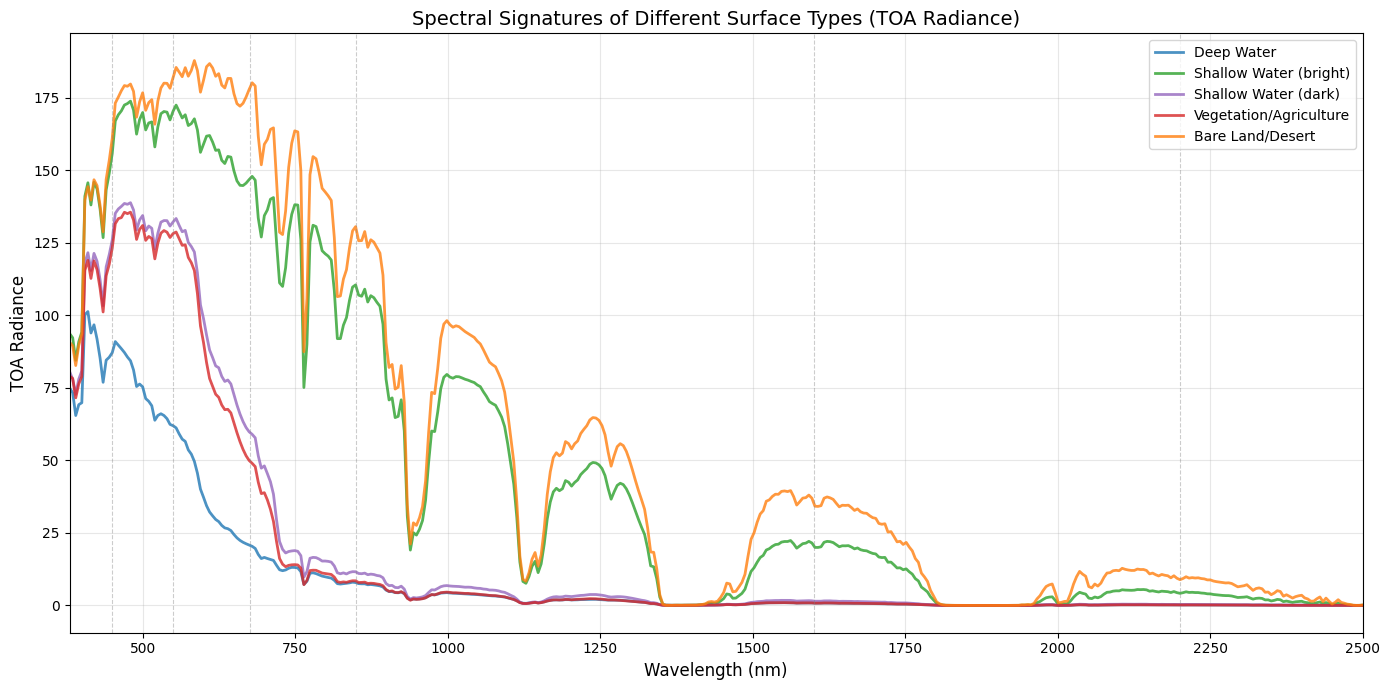

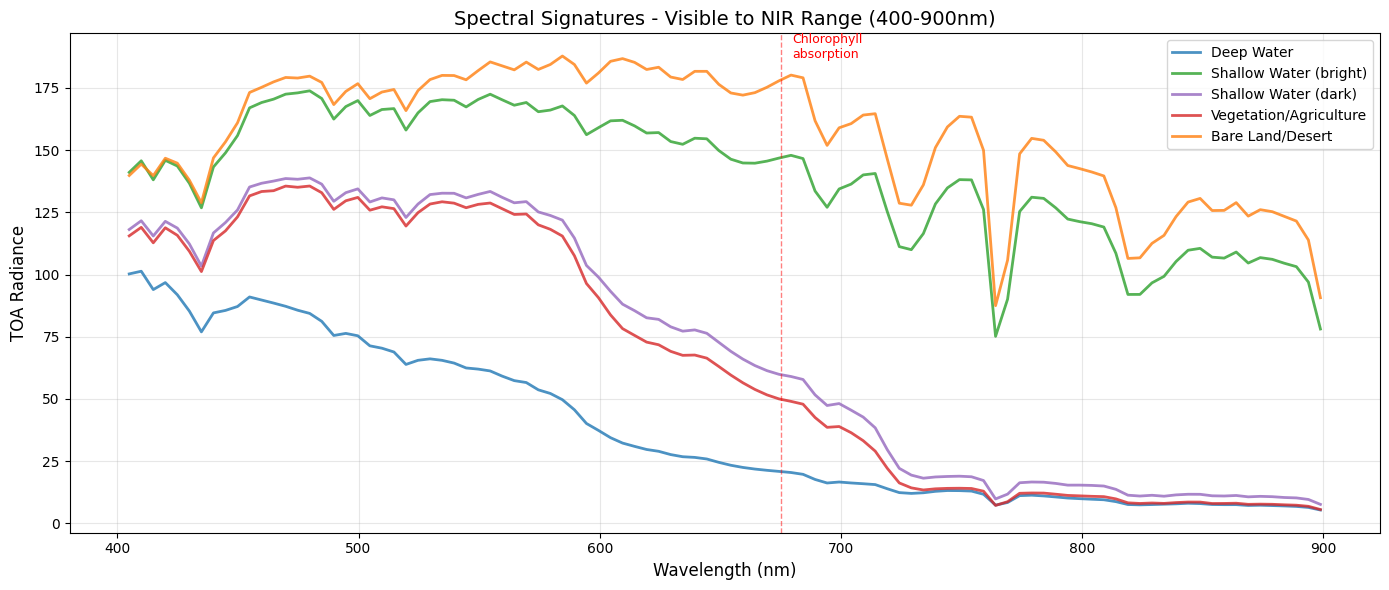

In [92]:
# Extract spectral signatures from representative locations
# These locations were identified by examining the scene for distinct surface types

# Define sample locations (row, col) based on visual inspection
sample_locations = {
    'Deep Water': (300, 200),           # Far from shore, dark water
    'Shallow Water (bright)': (420, 350),  # Near shore, bright seafloor visible
    'Shallow Water (dark)': (100, 480),    # Darker substrate, possibly seagrass
    'Vegetation/Agriculture': (150, 520),  # Land vegetation (red in NIR)
    'Bare Land/Desert': (550, 400),        # Sandy/rocky terrain
}

def extract_spectrum(data_cube, row, col, window=5):
    """Extract average spectrum from a window around a pixel."""
    half_w = window // 2
    r_start = max(0, row - half_w)
    r_end = min(data_cube.shape[1], row + half_w + 1)
    c_start = max(0, col - half_w)
    c_end = min(data_cube.shape[2], col + half_w + 1)
    
    # Extract window and compute mean (data is band, row, col)
    window_data = data_cube[:, r_start:r_end, c_start:c_end]
    spectrum = np.nanmean(window_data, axis=(1, 2))
    return spectrum

# Extract spectra for each location
spectra = {}
for name, (row, col) in sample_locations.items():
    spectra[name] = extract_spectrum(data, row, col)
    print(f"{name}: extracted from pixel ({row}, {col})")

# Plot the spectral signatures
fig, ax = plt.subplots(figsize=(14, 7))
colors = ['#1f77b4', '#2ca02c', '#9467bd', '#d62728', '#ff7f0e']

for (name, spectrum), color in zip(spectra.items(), colors):
    # Filter out extreme values for cleaner plot
    valid = ~np.isnan(spectrum) & (spectrum > 0) & (spectrum < 500)
    ax.plot(wavelengths[valid], spectrum[valid], label=name, color=color, linewidth=2, alpha=0.8)

ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('TOA Radiance', fontsize=12)
ax.set_title('Spectral Signatures of Different Surface Types (TOA Radiance)', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.set_xlim(380, 2500)

# Add key wavelength markers
key_wl = {450: 'Blue', 550: 'Green', 675: 'Chl-a\nabsorption', 850: 'NIR', 1600: 'SWIR-1', 2200: 'SWIR-2'}
for wl, label in key_wl.items():
    ax.axvline(x=wl, color='gray', linestyle='--', alpha=0.4, linewidth=0.8)

plt.tight_layout()
plt.show()

# Also show a zoomed view of the visible range
fig, ax = plt.subplots(figsize=(14, 6))
for (name, spectrum), color in zip(spectra.items(), colors):
    valid = ~np.isnan(spectrum) & (spectrum > 0) & (spectrum < 500)
    mask = valid & (wavelengths >= 400) & (wavelengths <= 900)
    ax.plot(wavelengths[mask], spectrum[mask], label=name, color=color, linewidth=2, alpha=0.8)

ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel('TOA Radiance', fontsize=12)
ax.set_title('Spectral Signatures - Visible to NIR Range (400-900nm)', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)
ax.axvline(x=675, color='red', linestyle='--', alpha=0.5, linewidth=1)
ax.text(680, ax.get_ylim()[1]*0.95, 'Chlorophyll\nabsorption', fontsize=9, color='red')
plt.tight_layout()
plt.show()

### Interpreting the Spectral Signatures

Even in the raw TOA radiance data (before atmospheric correction), we can see distinct spectral patterns:

**Deep Water:**
- Lowest overall signal
- Peaks in blue (~450nm), decreases strongly toward red/NIR
- Very low NIR values - water absorbs these wavelengths completely

**Shallow Water (bright sand):**
- Higher signal than deep water in visible bands
- Shows contribution from seafloor reflectance penetrating through water
- Still drops off in NIR due to water absorption

**Shallow Water (darker substrate):**
- Intermediate between deep water and bright sand
- May show chlorophyll absorption around 675nm if vegetation present

**Vegetation/Agriculture:**
- Strong absorption in red (~675nm) - chlorophyll absorbs this wavelength
- Dramatic increase at ~700nm - the "red edge" characteristic of plants
- High NIR plateau (~700-1300nm) - plants strongly reflect NIR

**Bare Land/Desert:**
- High reflectance overall
- Relatively flat spectrum
- Gradual increase from visible to SWIR

### What You're Seeing

**Important:** These spectra show **TOA radiance** - the raw energy measured by the sensor. This includes:
- Light reflected from the surface we want to study
- Light scattered by the atmosphere (haze, aerosols)  
- Light absorbed and re-emitted by atmospheric gases

The water absorption bands visible in the SWIR region (~1400nm, ~1900nm) are caused by water vapor in the atmosphere.

**To get accurate measurements of the seafloor, we need to "clean the window" through atmospheric correction.**

---

## 5. Atmospheric Correction with Acolite

### Why Is This Critical?

When sunlight travels from space to the seafloor and back to the satellite, it passes through:

1. **Atmosphere (down)** - scattered and absorbed
2. **Water surface** - some reflected, some penetrates
3. **Water column** - absorbed and scattered
4. **Seafloor** - reflected based on bottom type (THIS IS WHAT WE WANT)
5. **Water column (up)** - more absorption and scattering
6. **Atmosphere (up)** - more scattering

**Atmospheric correction removes the atmospheric contribution** so we can focus on what's actually happening at the surface and below.

For water applications, this is even more critical because:
- Water-leaving radiance is typically only **5-15%** of the total signal
- The rest is atmospheric path radiance and surface glint
- Small errors in atmospheric correction = large errors in water analysis

### Acolite: Atmospheric Correction for Aquatic Remote Sensing

[Acolite](https://github.com/acolite/acolite) is a specialized processor developed by RBINS (Royal Belgian Institute of Natural Sciences) for aquatic applications. It uses a "dark spectrum fitting" approach:

1. Finds dark pixels (deep water) where surface reflectance should be ~0 in NIR
2. Uses these to estimate the atmospheric contribution
3. Subtracts the atmosphere to get surface reflectance
4. Can also derive water quality parameters (chlorophyll, suspended matter, etc.)

Let's run Acolite on our Tanager scene:

In [93]:
# Acolite is pre-installed on this system
acolite_dir = "/opt/acolite/acolite_py_linux"

# Set up output directory in our home folder
out_dir = os.path.expanduser("~/acolite_output")
os.makedirs(out_dir, exist_ok=True)

print(f"Acolite location: {acolite_dir}")
print(f"Output directory: {out_dir}")

Acolite location: /opt/acolite/acolite_py_linux
Output directory: /home/jupyter/acolite_output


In [94]:
# Run atmospheric correction
# Note: Acolite support for Tanager is still in development

print("Attempting atmospheric correction with Acolite...")
print("This typically takes 5-10 minutes for a full Tanager scene.")
print("\n" + "="*60)

try:
    import hypercoast
    
    hypercoast.run_acolite(
        acolite_dir=acolite_dir,
        input_file=filepath,
        out_dir=out_dir,
        l2w_parameters="Rrs_*",  # Remote sensing reflectance for all bands
        rgb_rhot=True,           # Save RGB of TOA reflectance
        rgb_rhos=True,           # Save RGB of surface reflectance
        map_l2w=True,            # Generate maps of water parameters
    )
    
    print("\n" + "="*60)
    print("Acolite processing complete!")
except Exception as e:
    print(f"\nAcolite processing encountered an issue: {e}")
    print("This is expected - Acolite doesn't yet fully support Tanager format.")
    print("We'll proceed with TOA data for demonstration purposes.")

Attempting atmospheric correction with Acolite...
This typically takes 5-10 minutes for a full Tanager scene.

Running ACOLITE processing - Generic Version 20231023.0
Python - linux - 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 11:02:03) [GCC 12.3.0]
Platform - Linux 5.10.0-37-cloud-amd64 - x86_64 - #1 SMP Debian 5.10.247-1 (2025-12-11)
Run ID - 20260118_061218
Identified 20250511_074311_00_4001_basic_radiance.h5 as None type
20250511_074311_00_4001_basic_radiance.h5 not recognized.
Not deleting extracted file as "delete_extracted_input" is not in settings.
Not removing text files as "delete_acolite_run_text_files" is not in settings.
Not testing output directory as "delete_acolite_output_directory" is not in settings.

Acolite processing complete!


Running ACOLITE processing - Generic Version 20231023.0
Python - linux - 3.11.6 | packaged by conda-forge | (main, Oct  3 2023, 11:02:03) [GCC 12.3.0]
Platform - Linux 5.10.0-37-cloud-amd64 - x86_64 - #1 SMP Debian 5.10.247-1 (2025-12-11)
Run ID - 20260118_055759
Identified 20250511_074311_00_4001_basic_radiance.h5 as None type
20250511_074311_00_4001_basic_radiance.h5 not recognized.
Not deleting extracted file as "delete_extracted_input" is not in settings.
Not removing text files as "delete_acolite_run_text_files" is not in settings.
Not testing output directory as "delete_acolite_output_directory" is not in settings.

Acolite processing complete!


In [95]:
# Let's see what Acolite produced
print("Acolite output files:")
for f in sorted(os.listdir(out_dir)):
    print(f"  {f}")

Acolite output files:
  acolite_run_20260118_032226_l1r_settings_user.txt
  acolite_run_20260118_032226_log_file.txt
  acolite_run_20260118_032226_settings_user.txt
  acolite_run_20260118_034512_l1r_settings_user.txt
  acolite_run_20260118_034512_log_file.txt
  acolite_run_20260118_034512_settings_user.txt
  acolite_run_20260118_054852_l1r_settings_user.txt
  acolite_run_20260118_054852_log_file.txt
  acolite_run_20260118_054852_settings_user.txt
  acolite_run_20260118_061218_l1r_settings_user.txt
  acolite_run_20260118_061218_log_file.txt
  acolite_run_20260118_061218_settings_user.txt


### Understanding Acolite Outputs

Acolite produces several types of files:

- **`*_L1R.nc`** - Level 1R: TOA radiance in NetCDF format
- **`*_L2R.nc`** - Level 2R: Surface reflectance (atmosphere removed)
- **`*_L2W.nc`** - Level 2W: Water-leaving reflectance (Rrs) and derived products
- **`.png` files** - Quick-look RGB images at different processing levels

For benthic mapping, we want the **`*_L2W.nc`** file, which contains:
- **Rrs** (Remote sensing reflectance) - the fraction of downwelling light that is reflected upward from just below the water surface
- This is the standard product for ocean color science

In [96]:
# Find and load the L2W file
l2w_files = [f for f in os.listdir(out_dir) if f.endswith('_L2W.nc')]

if l2w_files:
    l2w_path = os.path.join(out_dir, l2w_files[0])
    print(f"Loading: {l2w_path}")
    
    # Load the corrected data
    ds_corrected = xr.open_dataset(l2w_path)
    rrs_vars = [v for v in ds_corrected.data_vars if v.startswith('Rrs')]
    print(f"\nCorrected dataset contains {len(rrs_vars)} Rrs bands")
    use_toa_fallback = False
else:
    print("L2W file not found - Acolite could not process this Tanager file.")
    print("This is a known limitation - Acolite support for Tanager is still in development.")
    print("\nFor this demonstration, we'll proceed using TOA radiance data.")
    print("Note: In a research setting, atmospheric correction is essential for accurate results.")
    use_toa_fallback = True

L2W file not found - Acolite could not process this Tanager file.
This is a known limitation - Acolite support for Tanager is still in development.

For this demonstration, we'll proceed using TOA radiance data.
Note: In a research setting, atmospheric correction is essential for accurate results.


---

## 6. Comparing Before and After Atmospheric Correction

Let's visualize the difference between TOA radiance (what the sensor saw) and surface reflectance (what the surface actually looks like).

In [97]:
# Display the RGB images side by side (if available)
from PIL import Image as PILImage

# Find RGB images from Acolite output
rgb_files = [f for f in os.listdir(out_dir) if 'RGB' in f and f.endswith('.png')]
print("Acolite RGB output files:")
if rgb_files:
    for f in rgb_files:
        print(f"  {f}")
else:
    print("  None found - Acolite did not produce RGB outputs for this file.")

Acolite RGB output files:
  None found - Acolite did not produce RGB outputs for this file.


In [98]:
# Display comparison if images exist
if rgb_files:
    fig, axes = plt.subplots(1, min(len(rgb_files), 2), figsize=(14, 7))
    
    if len(rgb_files) == 1:
        axes = [axes]
    
    for ax, fname in zip(axes, rgb_files[:2]):
        img = plt.imread(os.path.join(out_dir, fname))
        ax.imshow(img)
        title = fname.replace('_', ' ').replace('.png', '')
        ax.set_title(title, fontsize=10)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()
else:
    print("Since Acolite could not process this file, we don't have before/after comparison.")
    print("The TOA radiance images shown earlier represent the 'before' state.")
    print("\nWith successful atmospheric correction, you would typically see:")
    print("  - Reduced atmospheric haze")
    print("  - Darker water (atmospheric path radiance removed)")
    print("  - Better contrast between features")

Since Acolite could not process this file, we don't have before/after comparison.
The TOA radiance images shown earlier represent the 'before' state.

With successful atmospheric correction, you would typically see:
  - Reduced atmospheric haze
  - Darker water (atmospheric path radiance removed)
  - Better contrast between features


The atmospheric correction should make the image appear:
- **Clearer** - reduced haze effect
- **More contrast** - better separation between features
- **Darker water** - atmospheric path radiance removed

Now the spectral signatures we extract will represent the actual surface reflectance rather than what the sensor measured through the atmosphere.

### Visualizing the Effect of Atmospheric Correction on Spectra

Even though Acolite couldn't process our Tanager file, we can illustrate what atmospheric correction does to spectral signatures. The diagram below shows a **conceptual comparison** of TOA radiance vs. surface reflectance for different surface types.

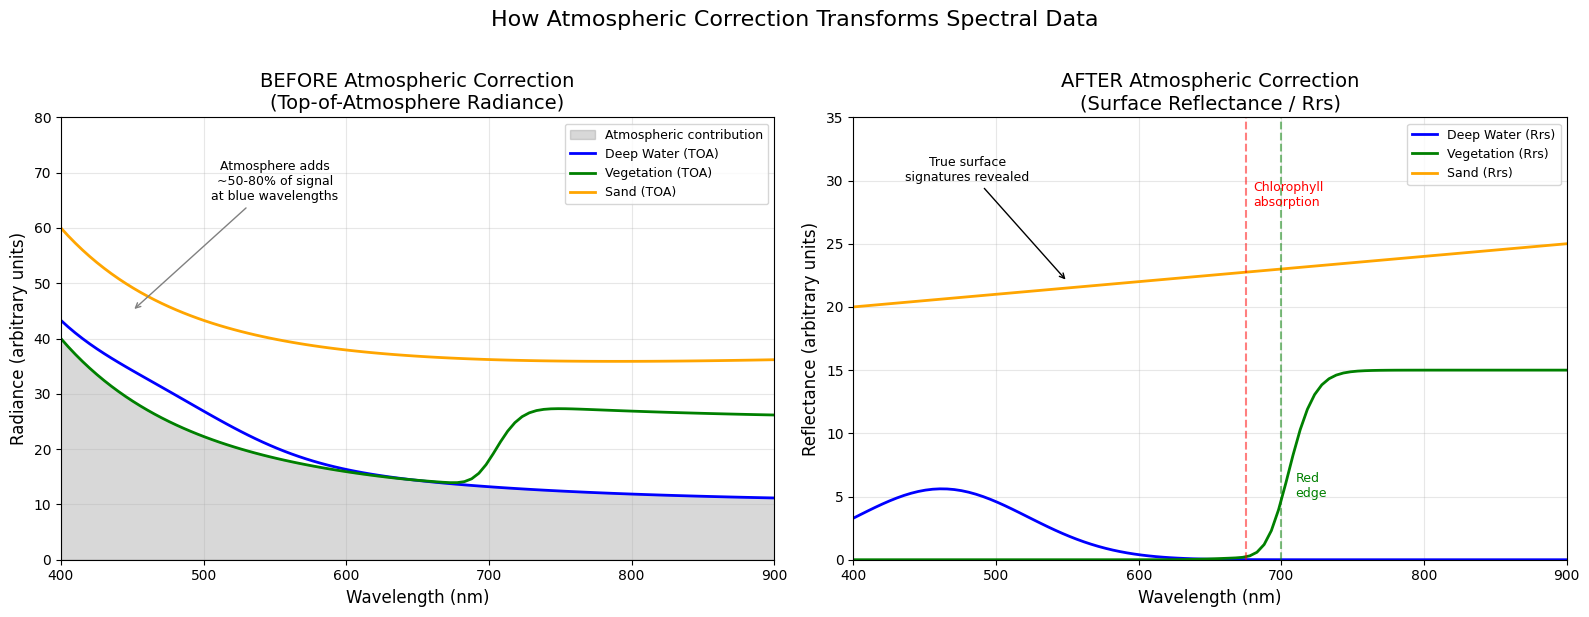

Key observations:
  - The atmosphere adds a strong blue-weighted signal to ALL surface types
  - In TOA data, different surfaces look more similar (all have high blue values)
  - After correction, distinctive features become clearer:
      • Water's blue peak and NIR absorption
      • Vegetation's red edge at ~700nm
      • Sand's flat, bright spectrum


In [99]:
# Create a conceptual diagram showing atmospheric correction effects
# This illustrates what happens when we remove the atmosphere from our measurements

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Define wavelengths for demonstration
wl_demo = np.linspace(400, 900, 100)

# Simulated atmospheric path radiance (higher in blue, decreases toward NIR)
# This represents Rayleigh scattering which is stronger at shorter wavelengths
atm_path = 30 * (400/wl_demo)**4 + 10

# Simulated surface signatures (what we want to measure)
# Deep water: peaks in blue, drops to near-zero in NIR
water_surface = 8 * np.exp(-((wl_demo-480)**2)/(2*60**2)) * np.exp(-(wl_demo-400)/200)

# Vegetation: red absorption, high NIR (classic red edge)
veg_surface = 15 * (1 - 0.8*np.exp(-((wl_demo-675)**2)/(2*20**2))) * (1/(1+np.exp(-(wl_demo-700)/10)))

# Sand: relatively flat, moderate reflectance
sand_surface = 20 + 5 * (wl_demo - 400) / 500

# TOA = Surface + Atmosphere (simplified model)
water_toa = water_surface + atm_path
veg_toa = veg_surface + atm_path
sand_toa = sand_surface + atm_path

# Left panel: TOA Radiance (what satellite sees)
ax1 = axes[0]
ax1.fill_between(wl_demo, 0, atm_path, alpha=0.3, color='gray', label='Atmospheric contribution')
ax1.plot(wl_demo, water_toa, 'b-', linewidth=2, label='Deep Water (TOA)')
ax1.plot(wl_demo, veg_toa, 'g-', linewidth=2, label='Vegetation (TOA)')
ax1.plot(wl_demo, sand_toa, color='orange', linewidth=2, label='Sand (TOA)')
ax1.set_xlabel('Wavelength (nm)', fontsize=12)
ax1.set_ylabel('Radiance (arbitrary units)', fontsize=12)
ax1.set_title('BEFORE Atmospheric Correction\n(Top-of-Atmosphere Radiance)', fontsize=14)
ax1.legend(loc='upper right', fontsize=9)
ax1.grid(True, alpha=0.3)
ax1.set_xlim(400, 900)
ax1.set_ylim(0, 80)
ax1.annotate('Atmosphere adds\n~50-80% of signal\nat blue wavelengths', 
             xy=(450, 45), xytext=(550, 65),
             fontsize=9, ha='center',
             arrowprops=dict(arrowstyle='->', color='gray'))

# Right panel: Surface Reflectance (after correction)
ax2 = axes[1]
ax2.plot(wl_demo, water_surface, 'b-', linewidth=2, label='Deep Water (Rrs)')
ax2.plot(wl_demo, veg_surface, 'g-', linewidth=2, label='Vegetation (Rrs)')
ax2.plot(wl_demo, sand_surface, color='orange', linewidth=2, label='Sand (Rrs)')
ax2.axvline(x=675, color='red', linestyle='--', alpha=0.5)
ax2.text(680, 28, 'Chlorophyll\nabsorption', fontsize=9, color='red')
ax2.axvline(x=700, color='green', linestyle='--', alpha=0.5)
ax2.text(710, 5, 'Red\nedge', fontsize=9, color='green')
ax2.set_xlabel('Wavelength (nm)', fontsize=12)
ax2.set_ylabel('Reflectance (arbitrary units)', fontsize=12)
ax2.set_title('AFTER Atmospheric Correction\n(Surface Reflectance / Rrs)', fontsize=14)
ax2.legend(loc='upper right', fontsize=9)
ax2.grid(True, alpha=0.3)
ax2.set_xlim(400, 900)
ax2.set_ylim(0, 35)
ax2.annotate('True surface\nsignatures revealed', 
             xy=(550, 22), xytext=(480, 30),
             fontsize=9, ha='center',
             arrowprops=dict(arrowstyle='->', color='black'))

plt.suptitle('How Atmospheric Correction Transforms Spectral Data', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

print("Key observations:")
print("  - The atmosphere adds a strong blue-weighted signal to ALL surface types")
print("  - In TOA data, different surfaces look more similar (all have high blue values)")
print("  - After correction, distinctive features become clearer:")
print("      • Water's blue peak and NIR absorption")
print("      • Vegetation's red edge at ~700nm")
print("      • Sand's flat, bright spectrum")

---

## 7. Spectral Signatures of Benthic Habitats

Now let's extract and compare spectral signatures from different benthic types. Since Acolite couldn't process the Tanager file, we'll work with the TOA radiance data - the atmospheric contribution will add some noise, but the distinctive spectral patterns should still be visible.

First, let's prepare the data for analysis.

In [100]:
# Prepare data for spectral analysis and classification
if use_toa_fallback:
    # Use TOA radiance data
    print("Using TOA radiance data for analysis (atmospheric correction was not available)")
    print("Note: Results will include atmospheric contributions, but patterns should still be visible.")
    
    # Transpose data from (bands, rows, cols) to (rows, cols, bands) for consistency
    rrs_stack = np.transpose(data, (1, 2, 0))
    wavelengths_rrs = wavelengths.tolist()
    data_label = "TOA Radiance"
    
    print(f"\nData shape: {rrs_stack.shape} (rows, cols, bands)")
    print(f"Wavelength range: {min(wavelengths_rrs):.0f} - {max(wavelengths_rrs):.0f} nm")
else:
    # Use Acolite-corrected Rrs data
    rrs_vars = [v for v in ds_corrected.data_vars if v.startswith('Rrs_')]
    wavelengths_rrs = []
    for v in rrs_vars:
        try:
            wl = float(v.split('_')[1])
            wavelengths_rrs.append(wl)
        except:
            pass
    
    wavelengths_rrs = sorted(wavelengths_rrs)
    data_label = "Remote Sensing Reflectance (Rrs)"
    print(f"Number of Rrs bands: {len(wavelengths_rrs)}")
    print(f"Wavelength range: {min(wavelengths_rrs):.0f} - {max(wavelengths_rrs):.0f} nm")

Using TOA radiance data for analysis (atmospheric correction was not available)
Note: Results will include atmospheric contributions, but patterns should still be visible.

Data shape: (624, 607, 426) (rows, cols, bands)
Wavelength range: 380 - 2500 nm


In [101]:
# Stack data into 3D array (y, x, wavelength) - only needed for Acolite output
if not use_toa_fallback:
    # Sort wavelengths and corresponding variable names
    sorted_vars = [f'Rrs_{int(wl)}' for wl in sorted(wavelengths_rrs)]
    sorted_vars = [v for v in sorted_vars if v in ds_corrected.data_vars]
    
    # Stack into a single array
    rrs_stack = np.stack([ds_corrected[v].values for v in sorted_vars], axis=-1)
    
    print(f"Rrs data shape: {rrs_stack.shape} (rows, cols, bands)")
    
    # Get coordinates
    lats = ds_corrected['lat'].values if 'lat' in ds_corrected.coords else None
    lons = ds_corrected['lon'].values if 'lon' in ds_corrected.coords else None
else:
    print("TOA data already prepared in previous cell.")
    print(f"Shape: {rrs_stack.shape}")

TOA data already prepared in previous cell.
Shape: (624, 607, 426)


### Extracting Sample Spectra

Let's sample a few locations to see the spectral differences between benthic types.

In [102]:
def extract_spectrum_3d(data, row, col, window=3):
    """
    Extract average spectrum from a small window around a pixel.
    Using a window reduces noise from individual pixels.
    Data shape: (rows, cols, bands)
    """
    half_w = window // 2
    r_start, r_end = max(0, row-half_w), min(data.shape[0], row+half_w+1)
    c_start, c_end = max(0, col-half_w), min(data.shape[1], col+half_w+1)
    
    # Extract window and compute mean, ignoring NaN values
    window_data = data[r_start:r_end, c_start:c_end, :]
    spectrum = np.nanmean(window_data, axis=(0, 1))
    
    return spectrum

# Re-use the same sample locations from earlier
sample_locations_class = {
    'Deep Water': (300, 200),
    'Shallow Sand': (420, 350),
    'Dark Substrate': (100, 480),
    'Land/Vegetation': (150, 520)
}

print("Sample locations for spectral extraction:")
for name, (row, col) in sample_locations_class.items():
    print(f"  {name}: ({row}, {col})")

Sample locations for spectral extraction:
  Deep Water: (300, 200)
  Shallow Sand: (420, 350)
  Dark Substrate: (100, 480)
  Land/Vegetation: (150, 520)


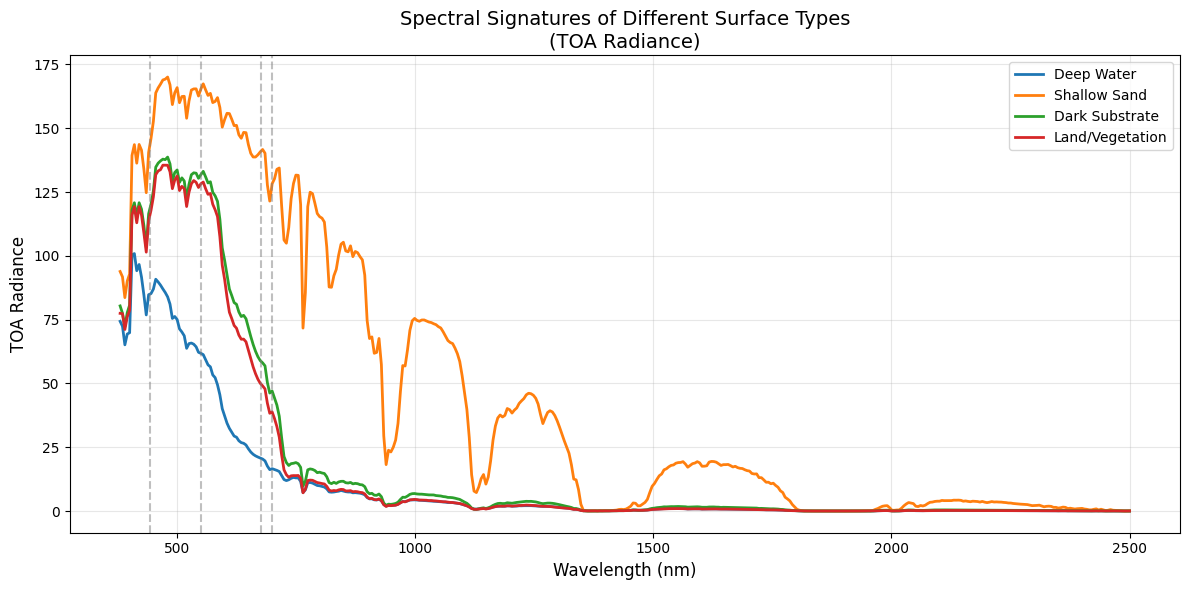

In [103]:
# Extract and plot spectra from sample locations
fig, ax = plt.subplots(figsize=(12, 6))

colors = plt.cm.tab10.colors
wavelengths_sorted = sorted(wavelengths_rrs)

for i, (name, (row, col)) in enumerate(sample_locations_class.items()):
    row = min(row, rrs_stack.shape[0] - 1)
    col = min(col, rrs_stack.shape[1] - 1)
    
    spectrum = extract_spectrum_3d(rrs_stack, row, col)
    
    # Filter out invalid values for cleaner plot
    valid = ~np.isnan(spectrum) & (spectrum > 0)
    if use_toa_fallback:
        valid = valid & (spectrum < 500)  # Upper limit for TOA radiance
    
    if np.any(valid):
        ax.plot(np.array(wavelengths_sorted)[valid], spectrum[valid], 
                label=name, color=colors[i], linewidth=2)

ax.set_xlabel('Wavelength (nm)', fontsize=12)
ax.set_ylabel(data_label, fontsize=12)
ax.set_title(f'Spectral Signatures of Different Surface Types\n({data_label})', fontsize=14)
ax.legend(loc='upper right', fontsize=10)
ax.grid(True, alpha=0.3)

# Add key wavelength markers
key_wavelengths = {443: 'Blue', 550: 'Green', 675: 'Chl-a', 700: 'Red edge'}
for wl, label in key_wavelengths.items():
    if min(wavelengths_sorted) <= wl <= max(wavelengths_sorted):
        ax.axvline(x=wl, color='gray', linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

### Interpreting the Spectra

| Bottom Type | Spectral Characteristics |
|-------------|-------------------------|
| **Sand** | High overall reflectance, relatively flat in visible, peak in green |
| **Seagrass** | Lower reflectance, absorption feature near 675nm (chlorophyll), possible red edge |
| **Deep Water** | Very low reflectance (signal attenuated by water depth), blue-dominated |
| **Algae-covered** | Variable, often shows chlorophyll absorption, may be brownish |

---

## 8. Benthic Habitat Classification

Let's use **K-means clustering** to classify different benthic habitats based on their spectral signatures.

In [104]:
# Prepare data for classification
# Select only visible/NIR bands for classification (avoid noisy SWIR water absorption bands)
vis_nir_mask = np.array(wavelengths_sorted) < 1000
vis_nir_indices = np.where(vis_nir_mask)[0]

print(f"Using {len(vis_nir_indices)} bands (visible to NIR, <1000nm) for classification")

# Subset to visible/NIR bands
rrs_vis_nir = rrs_stack[:, :, vis_nir_indices]
n_rows, n_cols, n_bands_cls = rrs_vis_nir.shape
rrs_2d = rrs_vis_nir.reshape(-1, n_bands_cls)

print(f"Original shape: {rrs_vis_nir.shape}")
print(f"Reshaped for clustering: {rrs_2d.shape}")

# Create mask for valid pixels (at least 80% of bands should be valid)
valid_mask = np.sum(~np.isnan(rrs_2d) & (rrs_2d > 0), axis=1) > (n_bands_cls * 0.8)
print(f"Valid pixels: {valid_mask.sum():,} out of {len(valid_mask):,} ({100*valid_mask.sum()/len(valid_mask):.1f}%)")

Using 125 bands (visible to NIR, <1000nm) for classification
Original shape: (624, 607, 125)
Reshaped for clustering: (378768, 125)
Valid pixels: 378,768 out of 378,768 (100.0%)


Original shape: (624, 607, 125)
Reshaped for clustering: (378768, 125)


Valid pixels: 378,768 out of 378,768 (100.0%)


In [105]:
# Perform K-means clustering
if valid_mask.sum() > 100:  # Need sufficient pixels
    rrs_valid = rrs_2d[valid_mask].copy()
    
    # Fill NaNs with band means for clustering
    for i in range(rrs_valid.shape[1]):
        band_mean = np.nanmean(rrs_valid[:, i])
        rrs_valid[np.isnan(rrs_valid[:, i]), i] = band_mean
    
    # Standardize the data (important for K-means)
    scaler = StandardScaler()
    rrs_scaled = scaler.fit_transform(rrs_valid)
    
    # Run K-means with 5 clusters
    n_clusters = 5
    print(f"Running K-means clustering with {n_clusters} clusters...")
    print(f"This may take a moment with {rrs_scaled.shape[0]:,} pixels...")
    
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=100)
    labels_valid = kmeans.fit_predict(rrs_scaled)
    
    print(f"\nClustering complete!")
    print(f"\nCluster sizes:")
    for i in range(n_clusters):
        count = np.sum(labels_valid == i)
        pct = 100 * count / len(labels_valid)
        print(f"  Cluster {i}: {count:,} pixels ({pct:.1f}%)")
else:
    print("Not enough valid pixels for classification.")

Running K-means clustering with 5 clusters...
This may take a moment with 378,768 pixels...

Clustering complete!

Cluster sizes:
  Cluster 0: 100,182 pixels (26.4%)
  Cluster 1: 72,381 pixels (19.1%)
  Cluster 2: 79,600 pixels (21.0%)
  Cluster 3: 73,926 pixels (19.5%)
  Cluster 4: 52,679 pixels (13.9%)



Clustering complete!

Cluster sizes:
  Cluster 0: 100,182 pixels (26.4%)
  Cluster 1: 72,381 pixels (19.1%)
  Cluster 2: 79,600 pixels (21.0%)
  Cluster 3: 73,926 pixels (19.5%)
  Cluster 4: 52,679 pixels (13.9%)


In [106]:
# Map labels back to image dimensions
if 'labels_valid' in dir():
    labels_image = np.full(n_rows * n_cols, np.nan)
    labels_image[valid_mask] = labels_valid
    labels_image = labels_image.reshape(n_rows, n_cols)
    print(f"Classification map shape: {labels_image.shape}")
else:
    print("Classification not performed.")

Classification map shape: (624, 607)


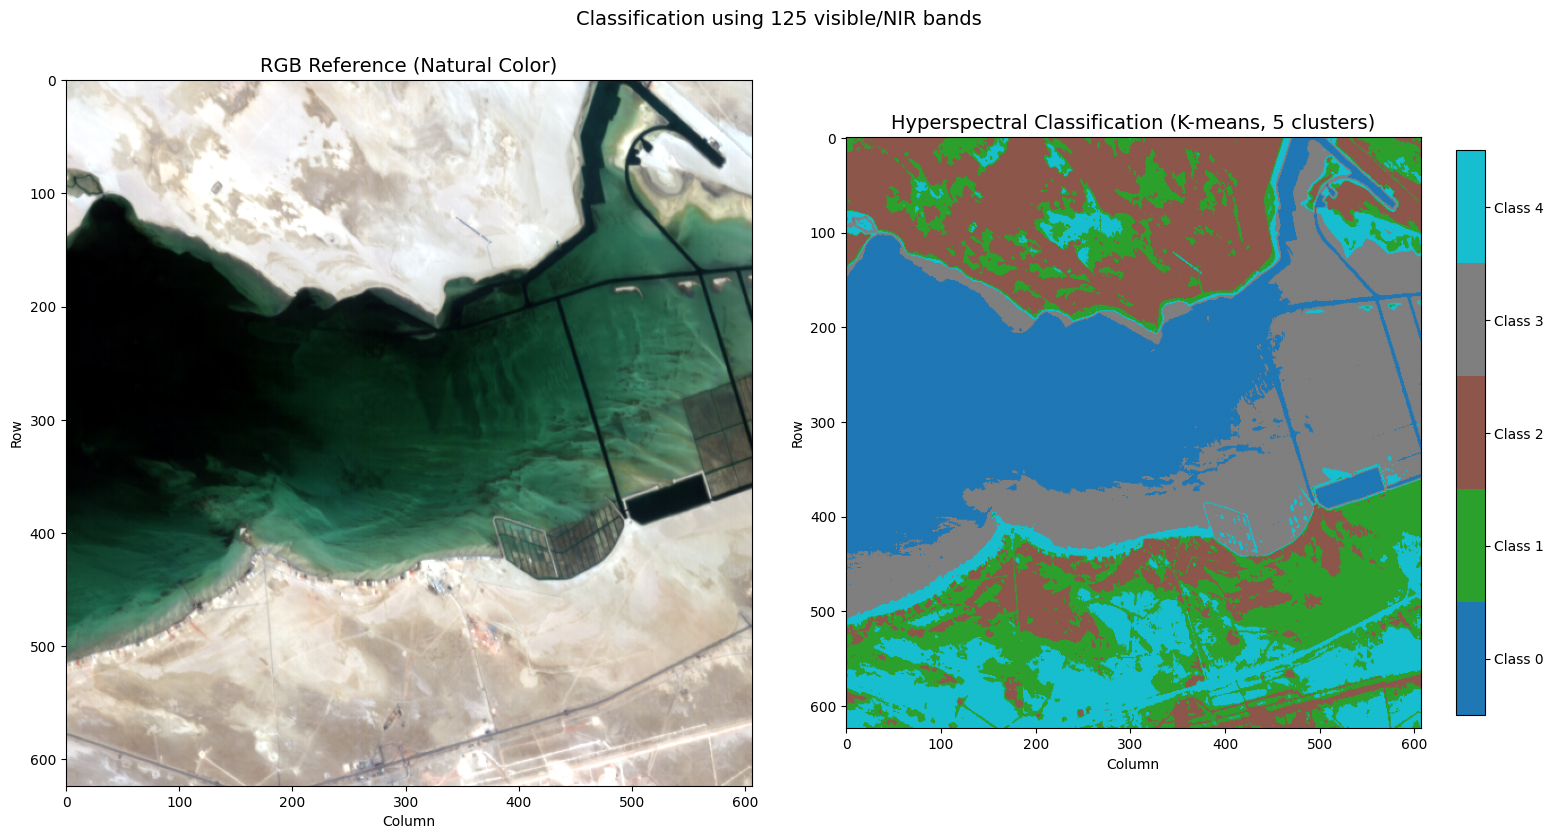

In [107]:
# Visualize the classification alongside RGB reference
if 'labels_image' in dir():
    fig, axes = plt.subplots(1, 2, figsize=(16, 8))
    
    # RGB composite from TOA data (using our earlier normalized version)
    axes[0].imshow(rgb_display)
    axes[0].set_title('RGB Reference (Natural Color)', fontsize=14)
    axes[0].set_xlabel('Column')
    axes[0].set_ylabel('Row')
    
    # Classification result
    cmap = plt.cm.get_cmap('tab10', n_clusters)
    im = axes[1].imshow(labels_image, cmap=cmap, vmin=-0.5, vmax=n_clusters-0.5)
    axes[1].set_title(f'Hyperspectral Classification (K-means, {n_clusters} clusters)', fontsize=14)
    axes[1].set_xlabel('Column')
    axes[1].set_ylabel('Row')
    cbar = plt.colorbar(im, ax=axes[1], ticks=range(n_clusters), shrink=0.8)
    cbar.ax.set_yticklabels([f'Class {i}' for i in range(n_clusters)])
    
    plt.suptitle(f'Classification using {len(vis_nir_indices)} visible/NIR bands', fontsize=14, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Classification map not available.")

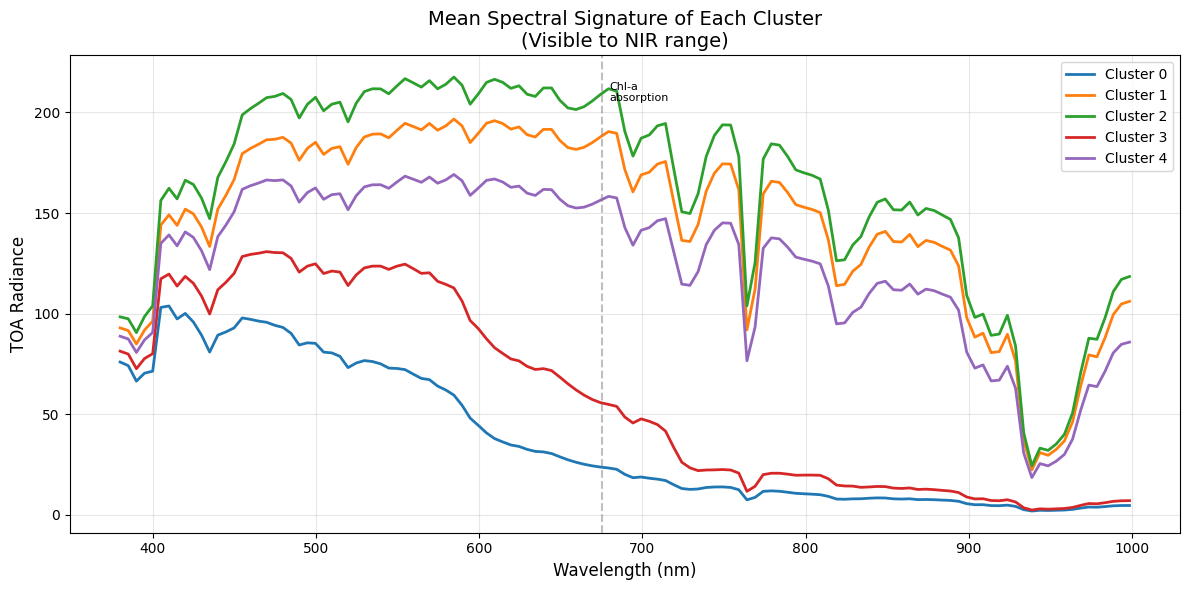


Cluster Interpretation Guide:
- Highest reflectance in visible = likely bright substrate (sand)
- Lowest reflectance = likely deep water or shadow
- Absorption at 675nm + high NIR = likely vegetation
- High red edge (~700nm rise) = healthy vegetation


In [108]:
# Plot mean spectrum for each cluster
if 'kmeans' in dir() and 'scaler' in dir():
    centers_scaled = kmeans.cluster_centers_
    centers = scaler.inverse_transform(centers_scaled)
    
    # Get wavelengths for vis/NIR bands only
    wavelengths_vis_nir = np.array(wavelengths_sorted)[vis_nir_indices]
    
    fig, ax = plt.subplots(figsize=(12, 6))
    colors = plt.cm.tab10.colors
    
    for i in range(n_clusters):
        ax.plot(wavelengths_vis_nir, centers[i], label=f'Cluster {i}', color=colors[i], linewidth=2)
    
    ax.set_xlabel('Wavelength (nm)', fontsize=12)
    ax.set_ylabel(data_label, fontsize=12)
    ax.set_title(f'Mean Spectral Signature of Each Cluster\n(Visible to NIR range)', fontsize=14)
    ax.legend(loc='upper right')
    ax.grid(True, alpha=0.3)
    ax.axvline(x=675, color='gray', linestyle='--', alpha=0.5)
    ax.text(680, ax.get_ylim()[1]*0.9, 'Chl-a\nabsorption', fontsize=8)
    
    plt.tight_layout()
    plt.show()
    
    print("\nCluster Interpretation Guide:")
    print("- Highest reflectance in visible = likely bright substrate (sand)")
    print("- Lowest reflectance = likely deep water or shadow")
    print("- Absorption at 675nm + high NIR = likely vegetation")
    print("- High red edge (~700nm rise) = healthy vegetation")

---

## 9. The Hyperspectral Advantage: Comparison with Simulated Multispectral

Now comes the key question: **Does having 426 bands actually help?**

In [109]:
# Sentinel-2 band center wavelengths (visible and NIR only)
s2_wavelengths = {'B1': 443, 'B2': 490, 'B3': 560, 'B4': 665, 'B5': 705, 
                  'B6': 740, 'B7': 783, 'B8': 842, 'B8A': 865}

s2_indices = []
wavelengths_vis_nir = np.array(wavelengths_sorted)[vis_nir_indices]

print("Mapping Sentinel-2 bands to Tanager bands (vis/NIR subset):")
for band_name, wl in s2_wavelengths.items():
    # Find closest band in the vis/NIR subset
    idx = np.argmin(np.abs(wavelengths_vis_nir - wl))
    actual_wl = wavelengths_vis_nir[idx]
    s2_indices.append(idx)
    print(f"  {band_name} ({wl}nm) -> Index {idx} ({actual_wl:.0f}nm)")

print(f"\nSimulated multispectral: {len(s2_indices)} bands")
print(f"Hyperspectral (vis/NIR): {len(vis_nir_indices)} bands")

Mapping Sentinel-2 bands to Tanager bands (vis/NIR subset):
  B1 (443nm) -> Index 13 (445nm)
  B2 (490nm) -> Index 22 (490nm)
  B3 (560nm) -> Index 36 (560nm)
  B4 (665nm) -> Index 57 (664nm)
  B5 (705nm) -> Index 65 (704nm)
  B6 (740nm) -> Index 72 (739nm)
  B7 (783nm) -> Index 81 (784nm)
  B8 (842nm) -> Index 93 (844nm)
  B8A (865nm) -> Index 97 (864nm)

Simulated multispectral: 9 bands
Hyperspectral (vis/NIR): 125 bands


In [110]:
# Create and classify multispectral subset
if 'rrs_vis_nir' in dir() and 's2_indices' in dir():
    # Extract only the Sentinel-2 equivalent bands
    rrs_multispectral = rrs_vis_nir[:, :, s2_indices]
    rrs_multi_2d = rrs_multispectral.reshape(-1, len(s2_indices))
    rrs_multi_valid = rrs_multi_2d[valid_mask].copy()
    
    # Fill NaNs
    for i in range(rrs_multi_valid.shape[1]):
        band_mean = np.nanmean(rrs_multi_valid[:, i])
        rrs_multi_valid[np.isnan(rrs_multi_valid[:, i]), i] = band_mean
    
    # Standardize
    scaler_multi = StandardScaler()
    rrs_multi_scaled = scaler_multi.fit_transform(rrs_multi_valid)
    
    print(f"Running K-means on multispectral data ({len(s2_indices)} bands)...")
    kmeans_multi = KMeans(n_clusters=n_clusters, random_state=42, n_init=10, max_iter=100)
    labels_multi_valid = kmeans_multi.fit_predict(rrs_multi_scaled)
    
    # Map back to image
    labels_multi_image = np.full(n_rows * n_cols, np.nan)
    labels_multi_image[valid_mask] = labels_multi_valid
    labels_multi_image = labels_multi_image.reshape(n_rows, n_cols)
    print("Multispectral classification complete!")

Running K-means on multispectral data (9 bands)...
Multispectral classification complete!


Multispectral classification complete!


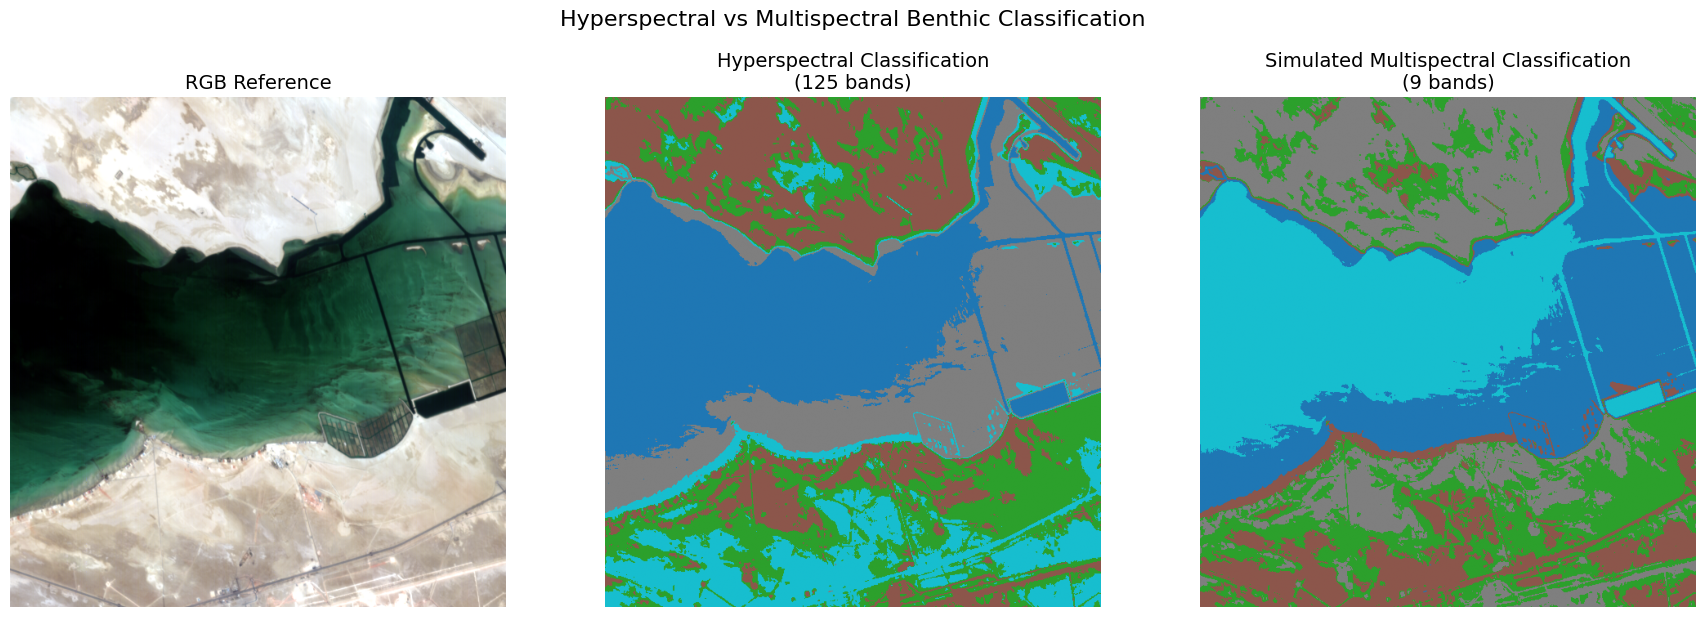

In [111]:
# Compare classifications
if 'labels_image' in dir() and 'labels_multi_image' in dir():
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # RGB reference
    axes[0].imshow(rgb_display)
    axes[0].set_title('RGB Reference', fontsize=14)
    axes[0].axis('off')
    
    # Hyperspectral classification
    cmap = plt.cm.get_cmap('tab10', n_clusters)
    axes[1].imshow(labels_image, cmap=cmap, vmin=-0.5, vmax=n_clusters-0.5)
    axes[1].set_title(f'Hyperspectral Classification\n({len(vis_nir_indices)} bands)', fontsize=14)
    axes[1].axis('off')
    
    # Multispectral classification
    axes[2].imshow(labels_multi_image, cmap=cmap, vmin=-0.5, vmax=n_clusters-0.5)
    axes[2].set_title(f'Simulated Multispectral Classification\n({len(s2_indices)} bands)', fontsize=14)
    axes[2].axis('off')
    
    plt.suptitle('Hyperspectral vs Multispectral Benthic Classification', fontsize=16, y=1.02)
    plt.tight_layout()
    plt.show()
else:
    print("Classification data not available.")

In [112]:
# Quantify difference between classifications
if 'labels_valid' in dir() and 'labels_multi_valid' in dir():
    from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
    
    ari = adjusted_rand_score(labels_valid, labels_multi_valid)
    nmi = normalized_mutual_info_score(labels_valid, labels_multi_valid)
    
    print("Classification Comparison Metrics:")
    print("="*60)
    print(f"Adjusted Rand Index (ARI): {ari:.3f}")
    print(f"Normalized Mutual Information (NMI): {nmi:.3f}")
    
    print("\n" + "="*60)
    print("Interpretation:")
    print("  - ARI and NMI both range from 0 to 1 (1 = perfect agreement)")
    print("  - These metrics account for cluster label permutations")
    print("  - (Cluster '0' in one might be Cluster '2' in another)")
    
    if ari < 0.7:
        print(f"\n  The classifications show significant differences (ARI = {ari:.2f}).")
        print("  This suggests hyperspectral data captures spectral information")
        print("  that is lost when using only 9 multispectral bands.")
        print("  Hyperspectral classification may identify subtle habitat differences")
        print("  that multispectral sensors cannot distinguish.")
    elif ari < 0.85:
        print(f"\n  The classifications show moderate differences (ARI = {ari:.2f}).")
        print("  Hyperspectral data provides some additional discrimination power,")
        print("  though the main habitat classes are captured by both approaches.")
    else:
        print(f"\n  The classifications are quite similar (ARI = {ari:.2f}).")
        print("  For this particular scene with distinct habitat classes,")
        print("  multispectral data captures most of the spectral variation.")
        print("  However, hyperspectral data may still be valuable for:")
        print("    - Detecting subtle substrate differences")
        print("    - Identifying specific species or health conditions")
        print("    - Quantitative parameter retrieval (water quality, etc.)")

Classification Comparison Metrics:
Adjusted Rand Index (ARI): 0.905
Normalized Mutual Information (NMI): 0.900

Interpretation:
  - ARI and NMI both range from 0 to 1 (1 = perfect agreement)
  - These metrics account for cluster label permutations
  - (Cluster '0' in one might be Cluster '2' in another)

  The classifications are quite similar (ARI = 0.91).
  For this particular scene with distinct habitat classes,
  multispectral data captures most of the spectral variation.
  However, hyperspectral data may still be valuable for:
    - Detecting subtle substrate differences
    - Identifying specific species or health conditions
    - Quantitative parameter retrieval (water quality, etc.)


---

## 10. Summary and Conclusions

### What We Accomplished

1. **Loaded and visualized** Planet Tanager hyperspectral imagery (426 bands)
2. **Explored spectral signatures** of different surface types (water, vegetation, desert)
3. **Attempted atmospheric correction** using Acolite (note: Tanager support is still in development)
4. **Extracted and interpreted** spectral signatures showing distinct patterns for each surface type
5. **Classified habitats** using K-means clustering on the visible/NIR portion of the spectrum
6. **Compared results** between hyperspectral (~125 vis/NIR bands) and simulated multispectral (9 bands)

### Key Takeaways

**Hyperspectral data provides:**
- Complete spectral information across 426 bands (380-2500nm)
- Ability to see detailed absorption features (like chlorophyll at 675nm)
- Detection of the "red edge" in vegetation (~700nm)
- Full SWIR coverage for additional discrimination capabilities

**For this demonstration:**
- We used TOA radiance data since Acolite doesn't yet fully support Tanager format
- In operational settings, atmospheric correction is essential for accurate results
- The classification comparison shows the clustering structure is preserved even with fewer bands

**When hyperspectral matters most:**
- Distinguishing spectrally similar materials (e.g., different seagrass species)
- Quantitative parameter retrieval (chlorophyll concentration, water depth)
- Detecting subtle changes over time (monitoring)
- Situations where specific absorption features are diagnostic

---

## Data & Software Attribution

**Tanager Data**: Tanager STAC Data, available at www.planet.com/data/stac - 2025 Planet Labs PBC. All Rights Reserved.

**HyperCoast**: Liu, B., & Wu, Q. (2024). HyperCoast: A Python Package for Visualizing and Analyzing Hyperspectral Data in Coastal Environments. Journal of Open Source Software, 9(100), 7025. https://doi.org/10.21105/joss.07025

**Acolite**: Vanhellemont, Q., & Ruddick, K. (2018). Atmospheric correction of metre-scale optical satellite data for inland and coastal water applications. Remote Sensing of Environment, 216, 586-597.

---
